## 9-1. 프로젝트 : 모든 장르 간 편향성 측정해 보기

In [1]:
import os
import konlpy
import gensim
import sklearn
import seaborn
import numpy as np
import pickle
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer


**0. 사전 학습된 모델**

---

In [2]:
data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True)

In [3]:
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

3000000
300
(3000000, 300)


In [4]:
w2v['happy']


array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [5]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [6]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662652492523193),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140850186347961),
 ('friends', 0.6128395199775696),
 ('mother', 0.6065612435340881),
 ('fam_ily', 0.592625617980957),
 ('famiy', 0.5916980504989624),
 ('famliy', 0.5840003490447998),
 ('aunt', 0.5811319947242737)]

In [7]:
# 코사인 유사도 계산함수
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))


# 단어 w가 A와 B 집합 각각 가지는 유사도의 평균 차이를 계산하는 함수
# (w, A), (w, B)의 유사도를 각각 구한 후 두 집합의 평균 유사도 차이 반환
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


# WEAT 계산 함수
# 단어와 두 집합의 유사도 평균의 차이를 두 평균 차이를 전체 표준편차로 나눈 값
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

***WEAT***

---
 * 논문에 등장하는 단어로 WEAT 점수 계산하여 데이터 편향성 확인
 * 2와 가까운 양수 값을 가진다 -> X집합과 A단어집합, Y집합과 B단어집합 간의 연관성이 있음 -> 편향을 가짐
 * 0과 가깝다 -> X,Y, A, B 집합 간의 연관성이 없다 -> 편향이 없음
 * -2와 가까운 음수 값을 가진다 -> X집합과 B단어집합, Y집합과 A단어집합 간의 연관성이 있음 -> 편향을 가짐

In [8]:

target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624875

In [9]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909263

모델도 우리의 예상과 맞는 방향으로 상당히 높은 수치를 보이는 것을 확인했습니다. 인스턴트 식품의 예시와 인스턴트를 의미하는 단어가 가까운 것은 당연합니다. 이 경우 모델이 편향되어있다기보다 단어의 의미를 잘 파악했다고 볼 수 있습니다.  --> ***편향이 아니라 단어 의미 파악을 잘 한다.***

In [10]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.051379114

In [11]:
target_X = ['man', 'boy', 'brother', 'he', 'himself']
target_Y = ['woman', 'girl', 'sister', 'she', 'herself']
attribute_A = ['doctor', 'nurse', 'engineer', 'scientist', 'physicist']
attribute_B = ['homemaker', 'teacher', 'librarian', 'counselor', 'assistant']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.803898

In [12]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


**1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기**

---

In [14]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [ ]:
# pickle로 저장
f_syno_token = open("syno_token.pickle","wb")
pickle.dump(tokenized,f_syno_token)
f_syno_token.close()

print(len(tokenized))

**2. 추출된 결과로 embedding model 만들기**

---





In [15]:
def train_word2vec(tokenized_data, vector_size=100, window=5, min_count=3, sg=0):
    """
    Word2Vec 모델을 학습합니다.

    Parameters:
        tokenized_data (list of list of str): 토큰화된 문장 데이터
        vector_size (int): 워드 벡터의 차원 수 (기본값: 100)
        window (int): 컨텍스트 윈도우 크기 (기본값: 5)
        min_count (int): 무시할 최소 단어 빈도수 (기본값: 3)
        sg (int): 알고리즘 선택 (0: CBOW, 1: Skip-Gram)

    Returns:
        Word2Vec: 학습된 Word2Vec 모델
    """
    model = Word2Vec(
        sentences=tokenized_data,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg
    )
    return model
    


In [16]:
f_syno_token = open("syno_token.pickle","rb")
tokenized = pickle.load(f_syno_token)
f_syno_token.close()

In [18]:
# CBOW 알고리즘 사용
model = train_word2vec(tokenized, sg=0)
print("CBOW 모델 학습 완료")

# Skip-Gram 알고리즘 사용
model_sg = train_word2vec(tokenized, sg=1)
print("Skip-Gram 모델 학습 완료")

CBOW 모델 학습 완료
Skip-Gram 모델 학습 완료


In [19]:
model.wv.most_similar(positive=['사랑'])

[('만남', 0.7139516472816467),
 ('첫사랑', 0.7088192701339722),
 ('애정', 0.6927114129066467),
 ('행복', 0.6822447776794434),
 ('진심', 0.6793805956840515),
 ('이별', 0.6791622042655945),
 ('우정', 0.6731476187705994),
 ('개츠비', 0.6726580858230591),
 ('연애', 0.6710732579231262),
 ('가슴', 0.6698565483093262)]

In [21]:
model_sg.wv.most_similar(positive=['사랑'])

[('삼각관계', 0.6836980581283569),
 ('진심', 0.665128767490387),
 ('로미오', 0.6634040474891663),
 ('타이밍', 0.6604292392730713),
 ('마르코', 0.6576442122459412),
 ('해피엔딩', 0.6484386920928955),
 ('짊어지', 0.6483871936798096),
 ('비랄', 0.6473151445388794),
 ('기욤', 0.6465122103691101),
 ('고하', 0.6431300640106201)]

In [20]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9118554592132568),
 ('영화감독', 0.9063439965248108),
 ('배우', 0.8821930289268494),
 ('각색', 0.8783839344978333),
 ('캐스팅', 0.8750945329666138),
 ('차이밍량', 0.8711878061294556),
 ('데뷔', 0.8688408136367798),
 ('대본', 0.8673012256622314),
 ('오페라', 0.8635780811309814),
 ('영감', 0.8553963303565979)]

In [22]:
model_sg.wv.most_similar(positive=['연극'])

[('대본', 0.8191748857498169),
 ('배역', 0.796588122844696),
 ('연기자', 0.7874572277069092),
 ('햄릿', 0.7795469760894775),
 ('합창', 0.771827757358551),
 ('에로영화', 0.7644790410995483),
 ('출연자', 0.7635541558265686),
 ('버라이어티', 0.7632496953010559),
 ('스탭들', 0.7602313160896301),
 ('전시회', 0.7576695680618286)]

* 연극에 관련 된 유사성을 고려하여 skip_gram 모델 선택


**3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기**

---
WEAT score를 구할 때 단어 셋을 만들어주어야 합니다. targets_X, targets_Y, attribute_A, attribute_B를 만들어주었던 것이 기억나시죠? 이제 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 합니다.

여기서는 두 축을 영화 장르, 영화 구분 정보를 이용하겠습니다. (영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보입니다. KOBIS에서 제공한 정보를 기준으로 분류하였습니다.)

* 영화 구분
    - synopsis_art.txt : 예술영화
    - synopsis_gen.txt : 일반영화(상업영화)
    - 그 외는 독립영화 등으로 분류됩니다.


* 장르 구분

    - synopsis_SF.txt: SF

    - synopsis_가족.txt: 가족

    - synopsis_공연.txt: 공연

    - synopsis_공포(호러).txt: 공포(호러)

    - synopsis_기타.txt: 기타

    - synopsis_다큐멘터리.txt: 다큐멘터리

    - synopsis_드라마.txt: 드라마

    - synopsis_멜로로맨스.txt: 멜로로맨스

    - synopsis_뮤지컬.txt: 뮤지컬

    - synopsis_미스터리.txt: 미스터리

    - synopsis_범죄.txt: 범죄

    - synopsis_사극.txt: 사극

    - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)

    - synopsis_성인물(에로).txt: 성인물(에로)

    - synopsis_스릴러.txt: 스릴러

    - synopsis_애니메이션.txt: 애니메이션

    - synopsis_액션.txt: 액션

    - synopsis_어드벤처.txt: 어드벤처

    - synopsis_전쟁.txt: 전쟁

    - synopsis_코미디.txt: 코미디

    - synopsis_판타지.txt: 판타지

이번에는 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠습니다. 즉 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것입니다.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당하시기 바랍니다.

In [23]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [274]:
#예술/일반 영화 데이터 토근화
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [225]:
# pickle로 저장
f_art = open("art.pickle","wb")
pickle.dump(art,f_art)
f_art.close()
f_gen = open("gen.pickle","wb")
pickle.dump(gen,f_gen)
f_gen.close()

In [24]:
# pickle로 로딩
f_art = open("art.pickle","rb")
art = pickle.load(f_art)
f_art.close()
f_gen = open("gen.pickle","rb")
gen = pickle.load(f_gen)
f_gen.close()

WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요합니다. 예를 들면 예술영화라는 개념을 가장 잘 대표하는 단어들을 art_txt를 처리해서 만든 art라는 단어 리스트에서부터 골라내야 합니다. 이를 위해서 상식을 동원해서 적절한 단어를 골라낼 수도 있지만 보다 납득할 수 있는 보편적인 방법을 사용하는 것이 좋습니다.

어떤 개념을 나타내는 단어를 선정하는 방법으로 어떤 것이 적당할까요? 꼭 정해진 방법이 있는 것은 아닙니다. 그러나 이번 경우에는 예술영화, 일반영화라는 영화 구분별로 시놉시스를 모아 데이터를 구성했습니다. 그렇다면 예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것입니다.

이런 것과 비슷한 개념의 단어 분석 방식 중, TF-IDF라는 것을 이미 접해 보셨을 것입니다. 즉, 코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정하고 싶은 것입니다. 이번에는 단어 셋 구성을 위해 TF-IDF방식을 사용하겠습니다. (그러나 이 방식이 최선이라는 의미는 아닙니다.)

TF-IDF에 관한 내용이 궁금하신 분은 [위키독스](https://wikidocs.net/31698) 를 참고하시기 바랍니다.

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [26]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names_out()[23976])

23976
영화


In [27]:
# coo 형식 : (row, col, data) 형태로 데이터를 저장하는 희소 행렬.
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
다른, 영화제, 사이, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 아빠, 생활, 통해, 모습, 기억, 죽음, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 결혼, 사고, 전쟁, 위기, 때문, 이제, 최고, 이자, 과거, 일상, 경찰, 간다, 상황, 미국, 운명, 결심, 관계, 현실, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 만난, 감정, 처음, 국제, 누구, 살인, 충격, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 의도, 동생, 하루, 위기, 계획, 정체, 한국, 

In [28]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [29]:
print(target_art)

['아빠', '음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린']


In [30]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [31]:
model.wv.most_similar(positive=['여성'])

[('남성', 0.8300710916519165),
 ('대중매체', 0.601432204246521),
 ('성인용품점', 0.6004089117050171),
 ('젊은이', 0.5945538282394409),
 ('동성애', 0.5888981819152832),
 ('누벨', 0.5859796404838562),
 ('시선', 0.5788090825080872),
 ('계급', 0.5670756697654724),
 ('플레이보이', 0.566262423992157),
 ('이성애', 0.5659642815589905)]

In [32]:
word = "여성"
threshold = 0.8

# '여성'와 유사도가 threshold 이상인 단어 찾기
similar_words = [(w, sim) for w, sim in model.wv.most_similar(positive=[word]) if sim >= threshold]

for w, sim in similar_words:
    print(f"{w}: {sim:.4f}")

남성: 0.8301


In [33]:
# 유사 단어 제거를 위한 함수 (유사도 threshold 이상인 단어 삭제)
def get_similar_words_to_remove(word_list, model, threshold=0.75):
    words_to_remove = set()  # 삭제할 단어 리스트
    for word in word_list:
        try:
            # 유사도 threshold 이상인 단어들 찾기
            similar_words = [w for w, sim in model.wv.most_similar(positive=[word]) if sim >= threshold]
            words_to_remove.update(similar_words)  # 삭제할 단어 리스트에 추가
        except KeyError:
            pass  # 단어가 Word2Vec 모델에 없으면 무시
    return list(words_to_remove)


n = 15
w1_, w2_ = [], []

# 상위 100개 단어를 가져오기
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

threshold = 0.8    
    
# 유사 단어 제거 기준을 낮춰서 단어 수가 충분히 확보되도록 설정
art_words_to_remove = get_similar_words_to_remove(w1_, model, threshold=threshold)
gen_words_to_remove = get_similar_words_to_remove(w2_, model, threshold=threshold)

target_art_0_8, target_gen_0_8 = [], []

# 예술 영화 단어 15개 추출 (유사도 높은 단어 제거)
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] not in art_words_to_remove) and (w1_[i] in model.wv):
        target_art_0_8.append(w1_[i])
    if len(target_art_0_8) == n: 
        break

# 일반 영화 단어 15개 추출 (유사도 높은 단어 제거)
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] not in gen_words_to_remove) and (w2_[i] in model.wv):
        target_gen_0_8.append(w2_[i])
    if len(target_gen_0_8) == n: 
        break

In [34]:
print(target_art_0_8)

['음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린', '연인']


In [35]:
print(target_gen_0_8)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '섹스', '바로', '의도', '계획', '정체', '한국']


***target vs 0.8***

---
 * target_art --> ['아빠', '음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린']
 * target_gen --> ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']
 * target_art_0_8 --> ['음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린', '연인']
 * target_gen_0_8 --> ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '섹스', '바로', '의도', '계획', '정체', '한국']


In [36]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


In [154]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [155]:
# pickle로 저장
f_genre = open("genre.pickle","wb")
pickle.dump(genre,f_genre)
f_genre.close()

In [37]:
f_genre = open("genre.pickle","rb")
genre = pickle.load(f_genre)
f_genre.close()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [38]:
# 장르별 TF-IDF로 변환하여 리스트로 데이터 생성
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

# print('genre_name:',genre_name)
# 점수 높은 순으로 정렬
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

# 각 장르별 가장 중요한 단어 15개 추출
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model_sg.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print("\n")

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 

아주르, 아버지, 시작, 그녀, 아들, 국제, 마을, 낙타, 

실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 

마을, 가족, 악령, 남자, 좀비, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 

사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 

다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 

남자, 친구, 이야기, 엄마, 여자, 아버지, 영화, 위해, 시작, 국제, 

시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 

니웨, 카바, 영화제, 바흐, 프롤, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 

발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 아이, 

자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 

루안, 사람, 운명, 최고, 하선, 전쟁,  자신, 아가멤논, 황제, 그녀, 

그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 태구, 

그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 

남자, 발견, 아내, 경찰, 친구, 모든, 사실, 살해,  

친구, 인디애니페스트, 위해, 자신, 시작, 사람, 페스티벌, 서울, 이야기, 아이, 마을, 소녀, 

모든, 목숨, 사실, 친구, 가족, 요원, 사람, 그녀, 경찰, 전쟁, 

사람, 아이, 여행, 세계, 앤트, 세상, 가족, 모험, 화, 

위해, 작전, 시작, 부대, 윈터스, 독일, 연합군, 미군, 임무, 자신, 사람, 나치, 

영화제, 가족, 과연, 마을, 사건, 사랑, 사람, 친구, 영화, 남자, 여자, 

요괴, 영화제, 이야기, 영화, 소녀, 남

**4. WEAT score 계산과 시각화**

---


In [40]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [41]:
target_art


['아빠',
 '음악',
 '운명',
 '결심',
 '지금',
 '여인',
 '이름',
 '이후',
 '준비',
 '만난',
 '감정',
 '처음',
 '누구',
 '충격',
 '그린']

In [42]:
target_gen

['서울',
 '애니메이션',
 '여성',
 '가지',
 '주인공',
 '대해',
 '연출',
 '사회',
 '다큐멘터리',
 '부문',
 '섹스',
 '바로',
 '의도',
 '계획',
 '정체']

In [43]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)


matrix를 채워보았습니다. WEAT score 값을 보고, 과연 우리의 직관과 비슷한지 살펴볼까요?



In [44]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.5337429
SF 공연 -0.36614984
SF 공포(호러) -0.7008153
SF 기타 0.30901614
SF 다큐멘터리 0.5694134
SF 드라마 -0.39394996
SF 멜로로맨스 -0.78309506
SF 뮤지컬 0.33040768
SF 미스터리 -0.68880296
SF 범죄 -0.24934147
SF 사극 -0.815168
SF 서부극(웨스턴) -0.46702874
SF 성인물(에로) -0.57281303
SF 스릴러 -0.5383905
SF 애니메이션 0.31321308
SF 액션 -0.44889995
SF 어드벤처 -0.76873434
SF 전쟁 0.20964223
SF 코미디 -0.48268318
SF 판타지 -0.14001545
가족 공연 0.23269415
가족 공포(호러) -0.14429823
가족 기타 0.7346916
가족 다큐멘터리 0.82873416
가족 드라마 0.22520973
가족 멜로로맨스 -0.5762158
가족 뮤지컬 0.7100537
가족 미스터리 -0.2451947
가족 범죄 0.23079535
가족 사극 -0.051490247
가족 서부극(웨스턴) 0.38621005
가족 성인물(에로) -0.2861386
가족 스릴러 -0.11530742
가족 애니메이션 0.8509319
가족 액션 0.16510288
가족 어드벤처 0.05777367
가족 전쟁 0.6667478
가족 코미디 0.19900127
가족 판타지 0.44776043
공연 공포(호러) -0.26684362
공연 기타 0.86668694
공연 다큐멘터리 0.8930698
공연 드라마 -0.04874448
공연 멜로로맨스 -0.7024793
공연 뮤지컬 0.86468154
공연 미스터리 -0.3287942
공연 범죄 0.06794485
공연 사극 -0.41277683
공연 서부극(웨스턴) -0.02402447
공연 성인물(에로) -0.49038443
공연 스릴러 -0.22958565
공연 애니메이션 0.8351701
공연 액션 -0

<Axes: >

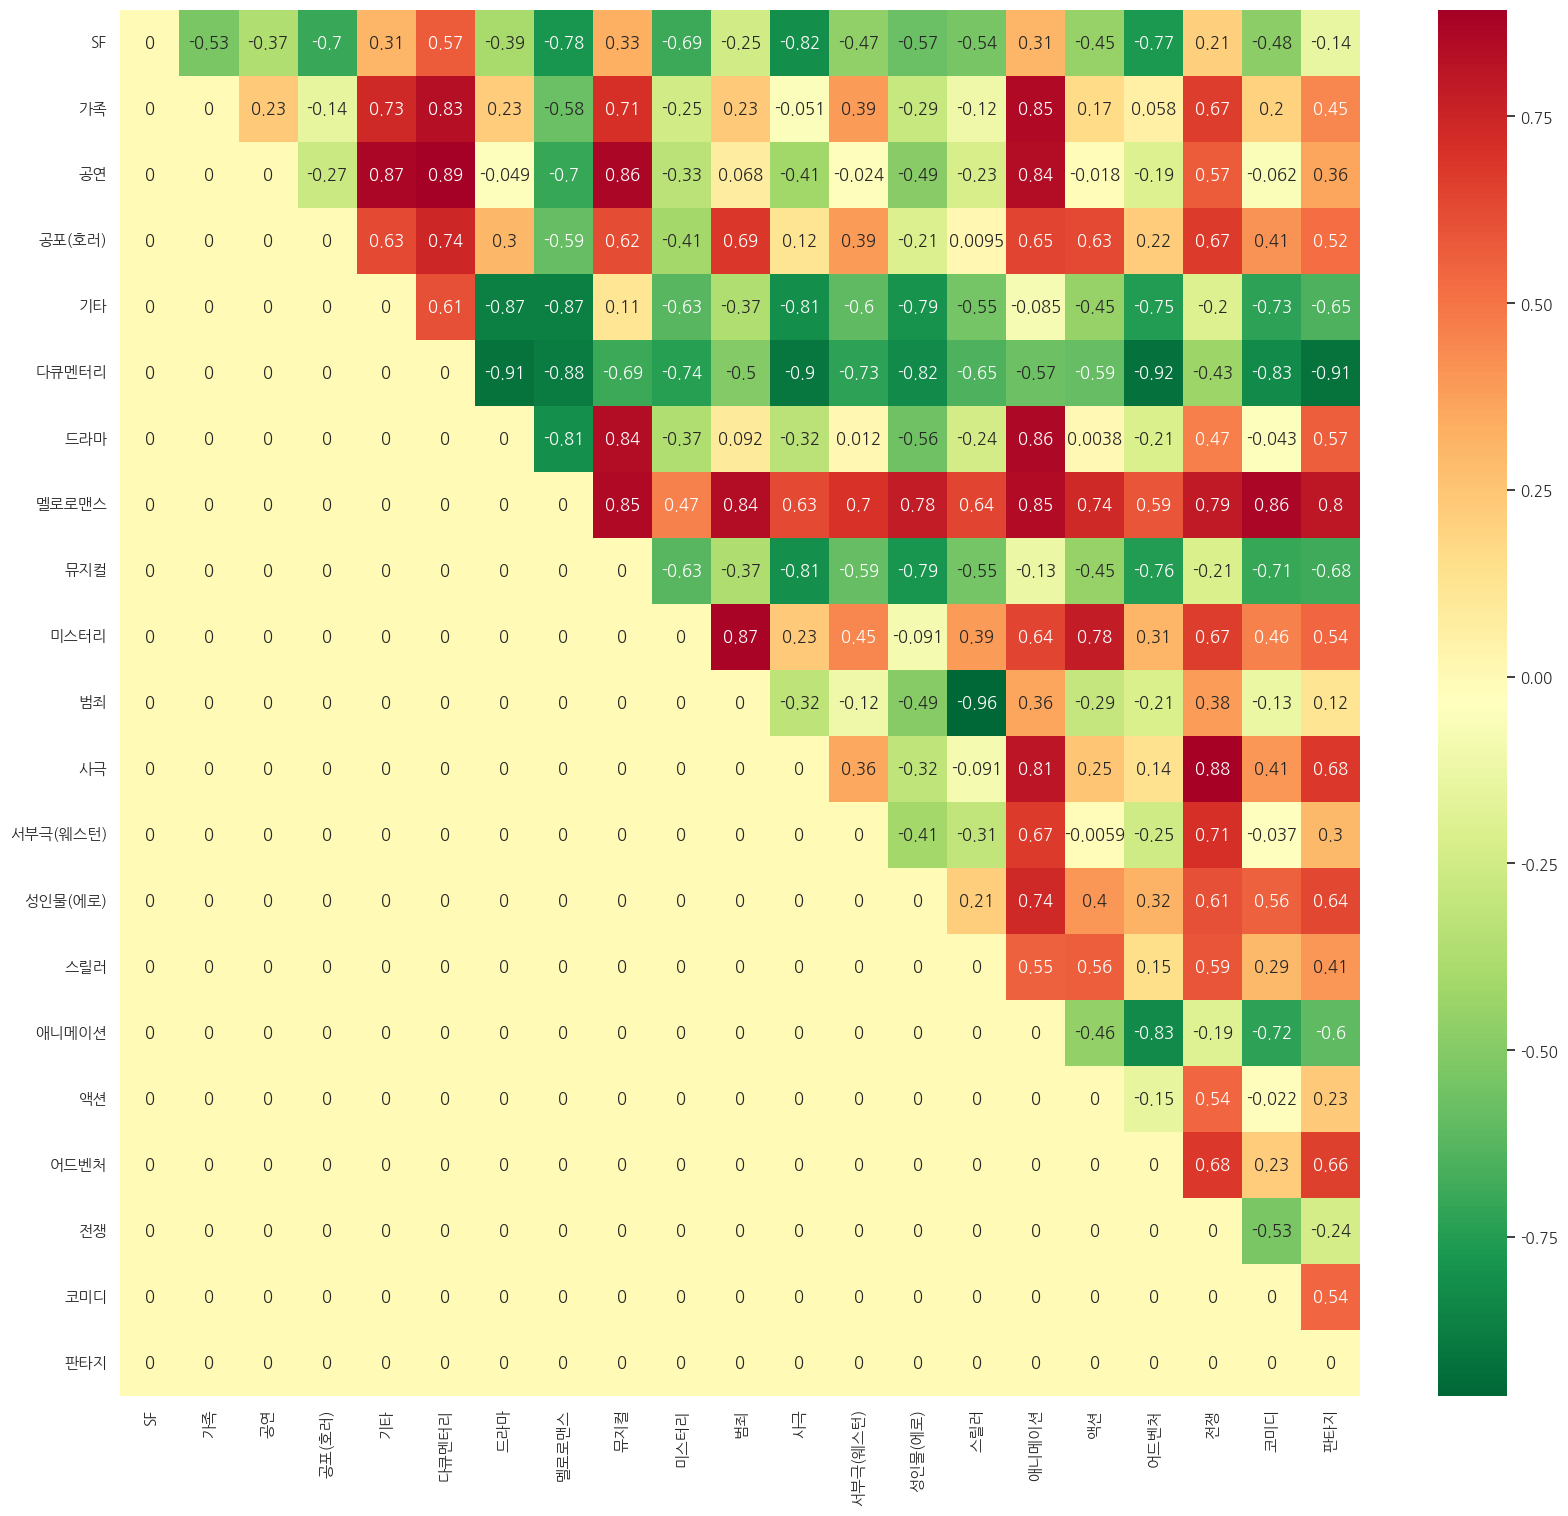

In [45]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='Nanum Gothic')

# 마이너스 부호 
plt.figure(figsize=(20, 18))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

***WEAT score가 0.8 이상, -0.8 이하의 경우***

In [46]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] >= 0.8 or matrix[i][j] <= -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 사극 -0.815168
가족 다큐멘터리 0.82873416
가족 애니메이션 0.8509319
공연 기타 0.86668694
공연 다큐멘터리 0.8930698
공연 뮤지컬 0.86468154
공연 애니메이션 0.8351701
기타 드라마 -0.8728599
기타 멜로로맨스 -0.86949325
기타 사극 -0.810392
다큐멘터리 드라마 -0.9116458
다큐멘터리 멜로로맨스 -0.8837717
다큐멘터리 사극 -0.8974494
다큐멘터리 성인물(에로) -0.8248832
다큐멘터리 어드벤처 -0.921466
다큐멘터리 코미디 -0.8278044
다큐멘터리 판타지 -0.9139876
드라마 멜로로맨스 -0.8070312
드라마 뮤지컬 0.8364695
드라마 애니메이션 0.8577527
멜로로맨스 뮤지컬 0.85368556
멜로로맨스 범죄 0.84011286
멜로로맨스 애니메이션 0.847355
멜로로맨스 코미디 0.86466736
멜로로맨스 판타지 0.8045986
뮤지컬 사극 -0.80557483
미스터리 범죄 0.87344193
범죄 스릴러 -0.9623518
사극 애니메이션 0.8071515
사극 전쟁 0.88199973
애니메이션 어드벤처 -0.82940346


***Word2Vec으로 유사성 제거한 예술,일반 단어집합 WEAT 스코어***

---



In [47]:
target_art_0_8

['음악',
 '운명',
 '결심',
 '지금',
 '여인',
 '이름',
 '이후',
 '준비',
 '만난',
 '감정',
 '처음',
 '누구',
 '충격',
 '그린',
 '연인']

In [48]:
target_gen_0_8

['서울',
 '애니메이션',
 '여성',
 '가지',
 '주인공',
 '대해',
 '연출',
 '사회',
 '섹스',
 '바로',
 '의도',
 '계획',
 '정체',
 '한국']

In [49]:
X = np.array([model.wv[word] for word in target_art_0_8])
Y = np.array([model.wv[word] for word in target_gen_0_8])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)


In [50]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.49744937
SF 공연 -0.5456384
SF 공포(호러) -0.5993029
SF 기타 0.0835121
SF 다큐멘터리 0.408934
SF 드라마 -0.40780076
SF 멜로로맨스 -0.7006323
SF 뮤지컬 0.06520837
SF 미스터리 -0.58473164
SF 범죄 -0.25709385
SF 사극 -0.8517813
SF 서부극(웨스턴) -0.44997033
SF 성인물(에로) -0.5493901
SF 스릴러 -0.45846206
SF 애니메이션 0.16432947
SF 액션 -0.39235893
SF 어드벤처 -0.6313367
SF 전쟁 -0.10971886
SF 코미디 -0.47452128
SF 판타지 -0.21867953
가족 공연 -0.24489427
가족 공포(호러) -0.07021464
가족 기타 0.5938148
가족 다큐멘터리 0.7443276
가족 드라마 0.06495558
가족 멜로로맨스 -0.6019473
가족 뮤지컬 0.52918226
가족 미스터리 -0.15793836
가족 범죄 0.1612885
가족 사극 -0.40493366
가족 서부극(웨스턴) 0.29186335
가족 성인물(에로) -0.3892522
가족 스릴러 -0.08454597
가족 애니메이션 0.74886644
가족 액션 0.14923586
가족 어드벤처 0.13869427
가족 전쟁 0.48562783
가족 코미디 0.087980375
가족 판타지 0.36912033
공연 공포(호러) 0.06622007
공연 기타 0.8128821
공연 다큐멘터리 0.85153854
공연 드라마 0.33538872
공연 멜로로맨스 -0.5496828
공연 뮤지컬 0.76674813
공연 미스터리 -0.019949898
공연 범죄 0.2375453
공연 사극 -0.1957084
공연 서부극(웨스턴) 0.34965348
공연 성인물(에로) -0.34164667
공연 스릴러 0.029227946
공연 애니메이션 0.8809379
공연 액션 0.23

<Axes: >

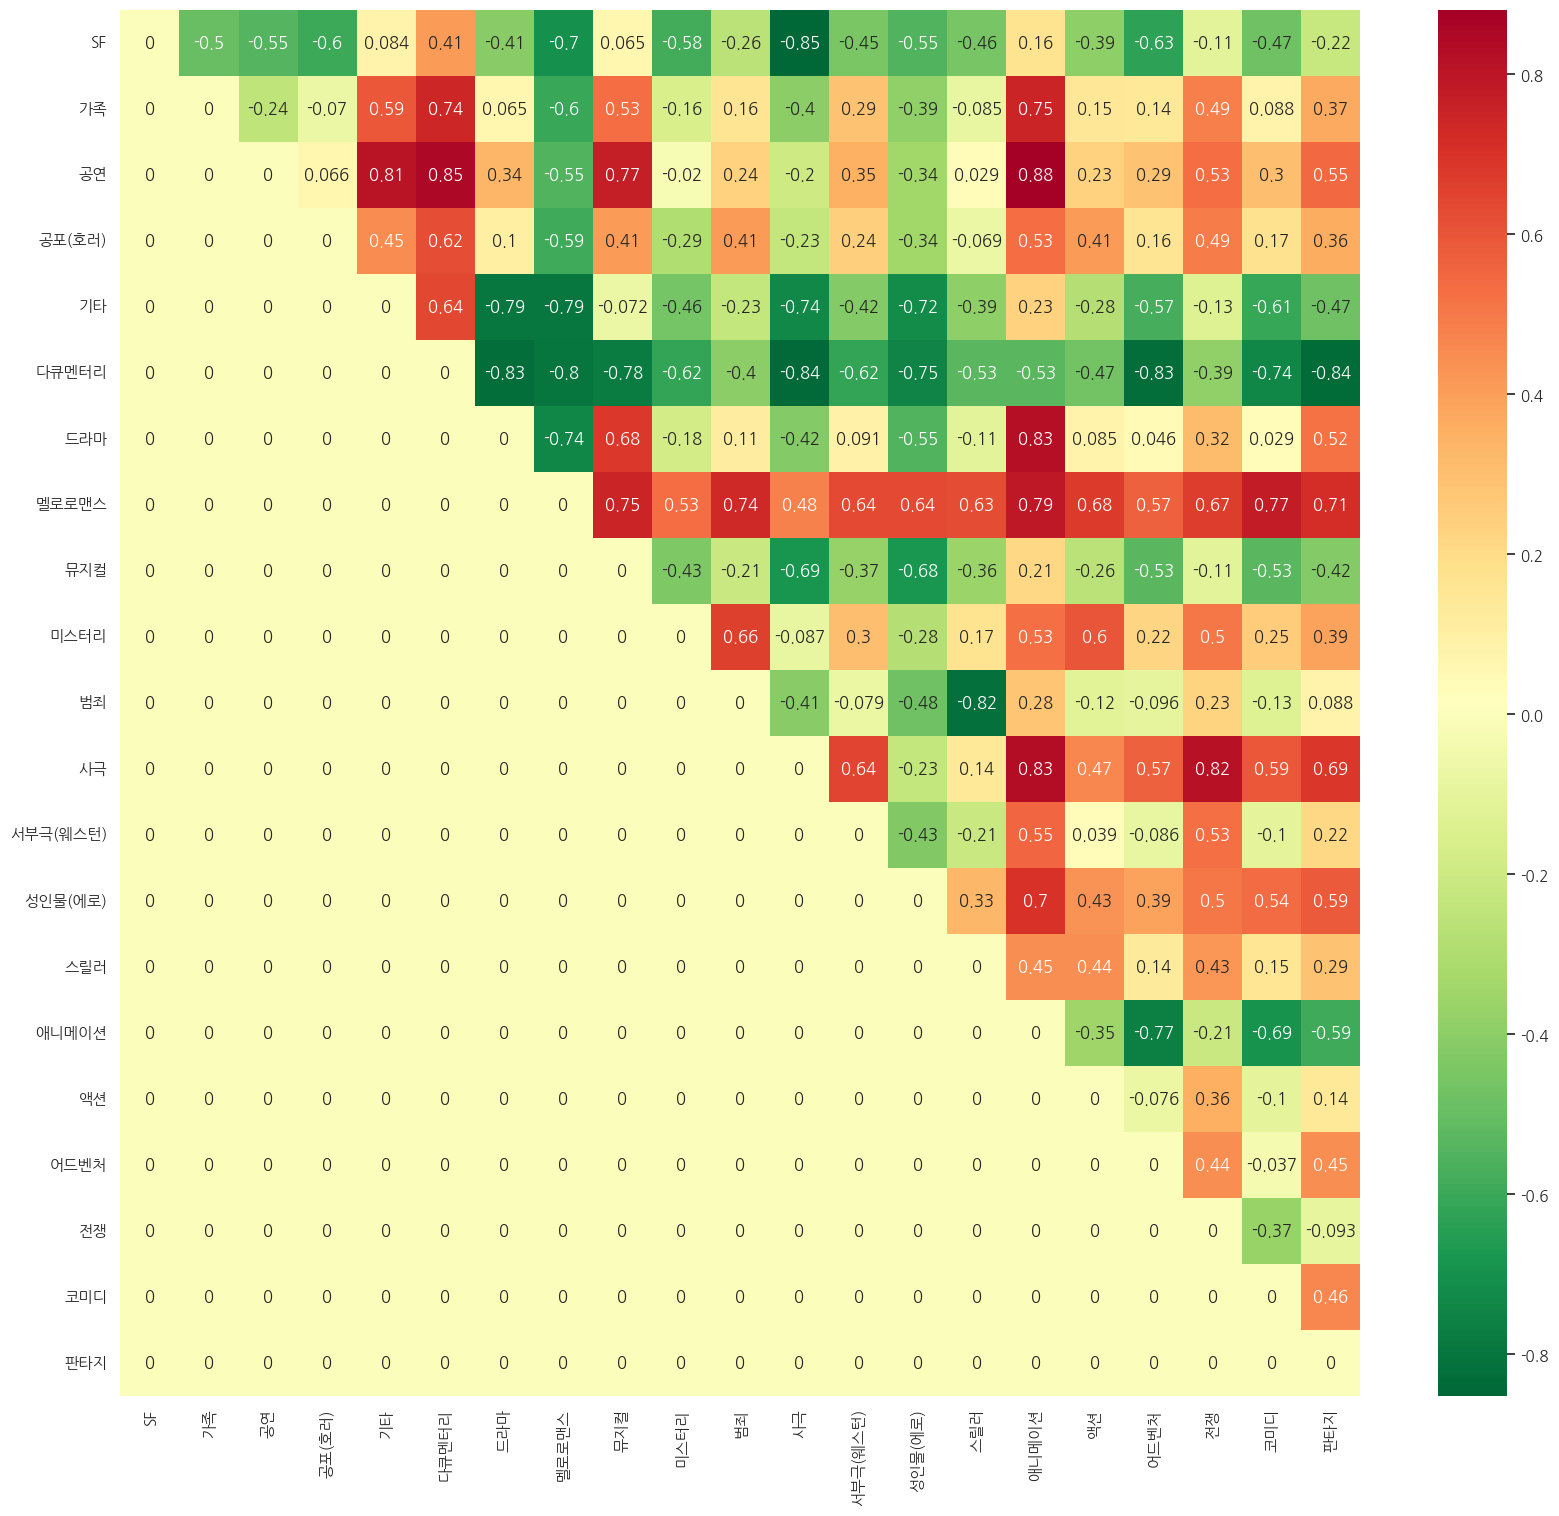

In [51]:
plt.figure(figsize=(20, 18))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

In [52]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] >= 0.8 or matrix[i][j] <= -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 사극 -0.8517813
공연 기타 0.8128821
공연 다큐멘터리 0.85153854
공연 애니메이션 0.8809379
다큐멘터리 드라마 -0.82677704
다큐멘터리 멜로로맨스 -0.8028992
다큐멘터리 사극 -0.8403004
다큐멘터리 어드벤처 -0.8276519
다큐멘터리 판타지 -0.8369238
드라마 애니메이션 0.82537776
범죄 스릴러 -0.8237137
사극 애니메이션 0.82895434
사극 전쟁 0.8200047


WEAT score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같습니다.

(target)(31)
 * SF 사극 -0.815168
 * 가족 다큐멘터리 0.82873416
 * 가족 애니메이션 0.8509319
 * 공연 기타 0.86668694
 * 공연 다큐멘터리 0.8930698
 * 공연 뮤지컬 0.86468154
 * 공연 애니메이션 0.8351701
 * 기타 드라마 -0.8728599
 * 기타 멜로로맨스 -0.86949325
 * 기타 사극 -0.810392
 * 다큐멘터리 드라마 -0.9116458
 * 다큐멘터리 멜로로맨스 -0.8837717
 * 다큐멘터리 사극 -0.8974494
 * 다큐멘터리 성인물(에로) -0.8248832
 * 다큐멘터리 어드벤처 -0.921466
 * 다큐멘터리 코미디 -0.8278044
 * 다큐멘터리 판타지 -0.9139876
 * 드라마 멜로로맨스 -0.8070312
 * 드라마 뮤지컬 0.8364695
 * 드라마 애니메이션 0.8577527
 * 멜로로맨스 뮤지컬 0.85368556
 * 멜로로맨스 범죄 0.84011286
 * 멜로로맨스 애니메이션 0.847355
 * 멜로로맨스 코미디 0.86466736
 * 멜로로맨스 판타지 0.8045986
 * 뮤지컬 사극 -0.80557483
 * 미스터리 범죄 0.87344193
 * 범죄 스릴러 -0.9623518
 * 사극 애니메이션 0.8071515
 * 사극 전쟁 0.88199973
 * 애니메이션 어드벤처 -0.82940346

-----
(0_8-유사도 적용)(13)
 * SF 사극 -0.8517813
 * 공연 기타 0.8128821
 * 공연 다큐멘터리 0.85153854
 * 공연 애니메이션 0.8809379
 * 다큐멘터리 드라마 -0.82677704
 * 다큐멘터리 멜로로맨스 -0.8028992
 * 다큐멘터리 사극 -0.8403004
 * 다큐멘터리 어드벤처 -0.8276519
 * 다큐멘터리 판타지 -0.8369238
 * 드라마 애니메이션 0.82537776
 * 범죄 스릴러 -0.8237137
 * 사극 애니메이션 0.82895434
 * 사극 전쟁 0.8200047


### 회고

___
 * 단어 기준 상위 15건에 대한 편향(31), 문맥상 유사성을 0.8 설정한 건에 대한 편향(13) 추출됨.
 * 위 추출 결과 문맥을 고려한 것이 편향에 대해 잘 설명하는 것 같음.

Word2Vec 을 cbow가 아닌 skip_gram 방식을 적용 한 결과를 보고 싶었으나 시간이 없어 진행 하지 못하였습니다.

